# Confidence Interval

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, sklearn.utils as skutils
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import bootstrap
import ipywidgets as widgets
from sklearn.utils import resample
import statsmodels.api as sm

rng = np.random.default_rng(2025)
sns.set_theme()

### Definitions 

- **Confidence interval** is a **range of values** used to estimate an unknown statistical parameter, that guarantees to **cover** the true parameter with a **pre-specified probability** under *repeated sampling from the population when all assumptions hold*. 

- **Confidence level**: The pre-specified probability of constructed intervals that cover the true parameter *under repeated sampling from the true population when all assumptions hold*.

- **Coverage**: The **empirical** probability that the constructed intervals contain the true parameter under repeated sampling from a hypothetical distribution (in simulation). This should equal the confidence level if all assumptions hold. 


### Coverage of Confidence Intervals


We fit a simple linear regression on the simulation data that, for $i=1,2,\ldots, n$
$$y_i = \beta_1 x_i + \beta_0 \epsilon_i,$$ 
where $\epsilon_i$ are i.i.d. $\mathcal{N}(0, \sigma^2)$. 

The $100(1-\alpha)\%$ confidence interval for the slope coefficient $\beta_1$ is
$$\hat{\beta}_1 \pm t^\star \cdot \text{SE}(\hat{\beta}_1),$$
where 
- $\text{SE}(\hat{\beta}_1) = \sqrt{ \dfrac{\hat{\sigma}^2}{\sum*{i=1}^n (x\_i - \bar{x})^2} }$
- $\hat{\sigma}^2 = \dfrac{1}{n-2} \sum\_{i=1}^n (y\_i - \hat{y}\_i)^2$ is the estimated variance of residuals
- $t^\star$ is the $100(1-\alpha/2)\%$ quantile of the \$t\$-distribution with $n - 2$ degrees of freedom.

The complete formula is 
$$
\left[
\hat{\beta}_1 - t^\star \cdot \sqrt{ \dfrac{\hat{\sigma}^2}{\sum_{i=1}^n (x_i - \bar{x})^2} }, \quad
\hat{\beta}_1 + t^\star \cdot \sqrt{ \dfrac{\hat{\sigma}^2}{\sum_{i=1}^n (x_i - \bar{x})^2} }
\right]
$$


In the numeric example below, we will generate data from a model 
$$y = 2x + \epsilon,$$ 
where $x \sim \mathcal{N}(0, 2)$ and $\epsilon \sim \mathcal{N}(0, 2)$. 
We will construct $100(1-\alpha)\%$ confidence intervals for $\beta_1$ from $5000$ simulation.

In [2]:
# Set parameters
n = 30
N_sim = 5000
true_beta1 = 2
alpha = 0.05
rng = np.random.default_rng()

In [3]:
# Storage for CIs
slope_CIs = []

for _ in range(N_sim):
    x = rng.normal(0, np.sqrt(2), n)
    eps = rng.normal(0, np.sqrt(2), n)
    y = true_beta1 * x + eps

    x_reshaped = x.reshape(-1, 1)
    model = LinearRegression().fit(x_reshaped, y)
    beta_hat = model.coef_[0]

    # Compute residuals and estimate variance
    y_pred = model.predict(x_reshaped)
    residuals = y - y_pred
    sigma_hat_sq = np.sum(residuals**2) / (n - 2)
    x_mean = np.mean(x)
    SE_beta = np.sqrt(sigma_hat_sq / np.sum((x - x_mean)**2))

    # t critical value
    t_crit = stats.t.ppf(1 - alpha/2, df=n-2)

    # Confidence interval
    lower = beta_hat - t_crit * SE_beta
    upper = beta_hat + t_crit * SE_beta
    slope_CIs.append((lower, upper))

# Convert to numpy array
slope_CIs = np.array(slope_CIs)


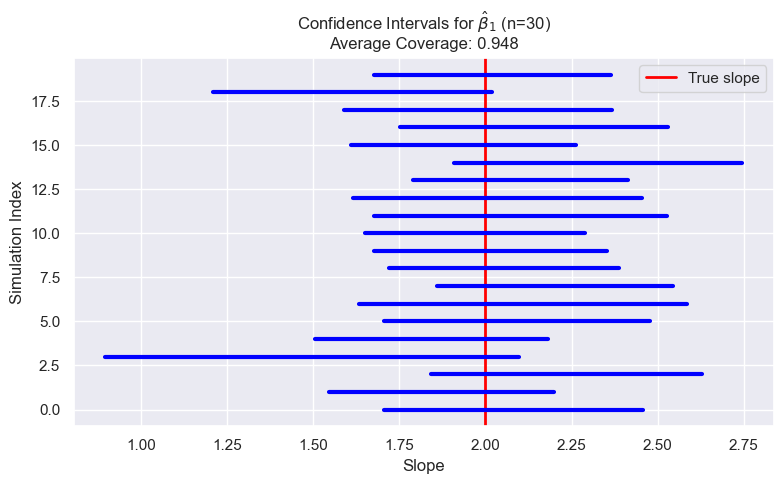

In [4]:
# Compute coverage
contains_true = (slope_CIs[:, 0] < true_beta1) & (slope_CIs[:, 1] > true_beta1)
coverage = np.mean(contains_true)

# Visualize 20 random intervals
plt.figure(figsize=(8, 5))
plt.title(f"Confidence Intervals for $\\hat{{\\beta}}_1$ (n={n})\nAverage Coverage: {coverage:.3f}")
plt.xlabel("Slope")
plt.ylabel("Simulation Index")
plt.axvline(true_beta1, color='red', linewidth=2, label='True slope')

# Pick 20 intervals to plot
start = 100
subset = range(start, start + 20)

for i, idx in enumerate(subset):
    l, u = slope_CIs[idx]
    color = 'blue' if (l < true_beta1 < u) else 'orange'
    plt.plot([l, u], [i, i], color=color, linewidth=3)

plt.legend()
plt.tight_layout()
plt.show()

### Boostrap Confidence Intervals 

The previous example requires analytic form of the asymptotic or finite-sample distributions of the estimators. Bootstrap offers a way to obtain the confidence intervals without deriving the theoretical sampling distribution under mild assumptions.  

**Example 1 – Penguin flipper length**  

Estimate the mean flipper length and bootstrapped 95 % CI.

In [5]:
rng = np.random.default_rng(0)

# load data 
penguins = sns.load_dataset("penguins").dropna(subset=["body_mass_g",
                                                       "flipper_length_mm"])
X = penguins["flipper_length_mm"].to_numpy()
y = penguins["body_mass_g"].to_numpy()

# statistic function: returns slope of resampled (x, y) pairs
def slope_stat(x, y):
    return np.polyfit(x, y, 1)[0]

boot_res = stats.bootstrap(
        data=(X, y),
        statistic=slope_stat,
        paired=True,               # resample (x, y) together
        vectorized=False,
        n_resamples=4000,
        confidence_level=0.95,
        method="percentile",
        random_state=rng
)

ci_boot = boot_res.confidence_interval
print(f"Bootstrap 95% CI for slope: [{ci_boot.low:.2f}, {ci_boot.high:.2f}] g/mm")


Bootstrap 95% CI for slope: [46.87, 52.51] g/mm


**Example 2 Confidence bands for nonparametric regression**

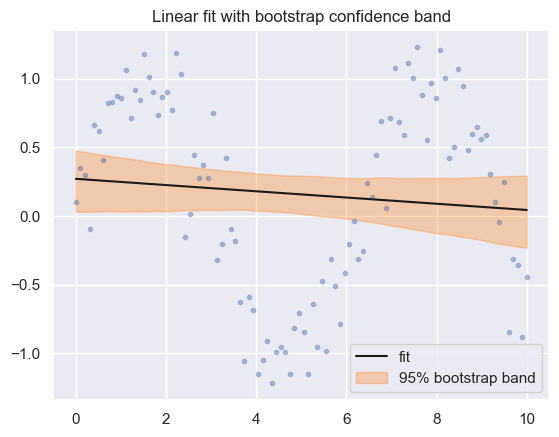

In [ ]:
rng = np.random.default_rng(1)
x = np.linspace(0, 10, 100)
y = np.sin(x) + rng.normal(0, .3, size=x.size)

model = LinearRegression().fit(x[:,None], y)
y_hat = model.predict(x[:,None])

B = 1000
boot_preds = []
for _ in range(B):
    xs, ys = resample(x, y, random_state=None)
    m = LinearRegression().fit(xs[:,None], ys)
    boot_preds.append(m.predict(x[:,None]))
boot_preds = np.vstack(boot_preds)
lower, upper = np.percentile(boot_preds, [2.5, 97.5], axis=0)

plt.plot(x, y, '.', alpha=.4)
plt.plot(x, y_hat, 'k', label='fit')
plt.fill_between(x, lower, upper, color='tab:orange', alpha=.3,
                 label='95% bootstrap band')
plt.legend(); plt.title("Linear fit with bootstrap confidence band")
plt.show()